原始链接：http://nlp.seas.harvard.edu/2018/04/03/attention.html   
参考链接：http://jalammar.github.io/illustrated-transformer/

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context='talk')
%matplotlib inline

# 模型架构
Transformer整体架构
       
<img src="https://gitee.com/nie-shiqin/typora_pic/raw/master/img/20240919183907.png" width="50%">

### 通用的 **编码器解码器** 架构：

In [2]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        """
        编码器、解码器、输入嵌入层、目标嵌入层、输出层
        整体流程如下：
        1. src原输入通过src_embed嵌入层，得到src_embed
        2. src_embed和src_mask通过encoder编码器，得到memory
        3. tgt原输入通过tgt_embed嵌入层，得到tgt_embed
        4. memory、src_mask、tgt_embed、tgt_mask通过decoder解码器，得到output
        """
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        src --> memory
        memory + tgt --> output
        """
        memory = self.encode(src, src_mask) # mask掩盖变长序列的填充值，例如padding
        return self.decode(memory, src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        """
        src --> memory
        """
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        """
        memory + tgt --> output
        """
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [3]:
class Generator(nn.Module):
    '''定义标准的线性 + softmax 生成步骤。'''
    
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## 编码器
编码器由多层 `N=6` 完全相同的层堆叠而成


<img src="https://gitee.com/nie-shiqin/typora_pic/raw/master/img/20240919185334.png" width="60%">


其层次结构如上图中所示：
```
1. Encoder
    2. EncoderLayer
        3. SublayerConnection
            4. sublayer --> self_attn
            
        3. SublayerConnection
            4. sublayer --> feed_forward
            
    2. EncoderLayer
    .
    .
    .
    .
```

In [4]:
def clone(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

### 层归一化

In [5]:
class LayerNorm(nn.Module):
    """
    inputs: batch, seq_len, features
    沿输入数据的特征维度进行层归一化
    """
    def __init__(self, features, eps=1e-6):
        # 需要指定特征数量 features
        # eps：防止除0错误
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.ones(features)) #均为(features,)的张量
        self.eps = eps

    def forward(self, x):
        """
        x --> (x - x.mean) / x.std 
        """
        mean = x.mean(-1, keepdim=True) # -1维度是特征维度，因此沿着输入张量的最后一个维度（即特征维度）进行计算，并保持计算后的张量的维度不变。
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

### Encoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clone(layer, N)
        self.norm = LayerNorm(layer.size) # layer.size = 特征维度/特征数量

    def forward(self, x, mask):
        """
        需要自主生成 mask 
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [9]:
def test_layernorm():
    x = np.array([[[1, 2, 3], [2, 4, 5]],],
                 dtype=np.float)
    print('x.shape:', x.shape)
    print('特征数量：', x.shape[-1])
    print("Before Norm: \n", x)
    x = torch.from_numpy(x)  # batch, seq_len, features
    norm = LayerNorm(x.shape[-1])
    x = norm(x)
    print("After Norm: \n", x.detach().numpy())


test_layernorm()

x.shape: (1, 2, 3)
特征数量： 3
Before Norm: 
 [[[1. 2. 3.]
  [2. 4. 5.]]]
After Norm: 
 [[[ 9.99999000e-07  1.00000000e+00  1.99999900e+00]
  [-9.10887369e-02  1.21821775e+00  1.87287099e+00]]]


/tmp/ipykernel_2828819/1609628008.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.float)


### 残差连接和归一化层

In [10]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        """
        指定内部的结构 sublayer，是 attention 层，还是 feed_forward 层
        """
        return x + self.dropout(sublayer(self.norm(x)))

In [11]:
class EncoderLayer(nn.Module):
    """size: d_model"""
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clone(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # 调用了sublayerconnection实例的forward方法，使用了self_attn
        return self.sublayer[1](x, self.feed_forward) # 使用了feed_forward对特征进一步进行非线性映射，学习输入特征中的复杂非线性关系，从而增强表示能力。

## 解码器
<img src="https://gitee.com/nie-shiqin/typora_pic/raw/master/img/20240919185548.png" width="60%">

In [12]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clone(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size  # 作为参数用于 layernorm 层
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clone(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask)) # 输出向量自注意
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask)) # 输出和输入序列的注意力
        return self.sublayer[2](x, self.feed_forward)

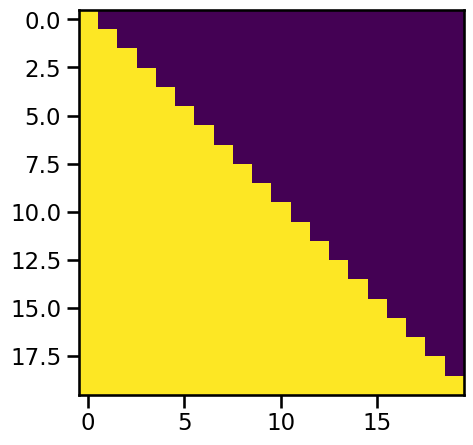

In [14]:
# 解码器一次输入序列中向量，当前步后面的序列需要被遮盖——防止信息泄露
# 需要被遮盖的单词被标记为 False 

def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(20)[0])

`np.triu(m,k=0)`：第 k 对角线以下的元素归零，中心对角线索引为 0 ，索引向右上角增加 1、2、3 ，向左下角-1、-2、-3
```
>>> np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], -1)
array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 0,  8,  9],
       [ 0,  0, 12]])
```

## 注意力
### 点积注意力
<img src="https://gitee.com/nie-shiqin/typora_pic/raw/master/img/20240919185706.png" width="30%">
<img src="https://gitee.com/nie-shiqin/typora_pic/raw/master/img/20240919185801.png" width="30%">

In [15]:
def attention(query, key, value, mask=None, dropout=None):
    """
    query : batch, target_len, feats
    key   : batch, seq_len,    feats
    value : batch, seq_len,    val_feats
    
    return: batch, target_len, val_feats
    """
    d_k = query.size(-1) # key向量的特征数量 
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # 转置key的后两个维度

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
        
    # 将注意力得分转换为注意力权重，即概率的形式
    p_attn = F.softmax(scores, dim=-1) # 最后一维是seq_len, 在每一个查询位置上对所有键的位置进行softmax

    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn # 注意力输出，注意力权重

In [16]:
def test_attention():
    query = torch.randn(3, 5, 4)  # batch, target_len, feats
    key = torch.randn(3, 6, 4)  # batch, seq_len, feats
    value = torch.randn(3, 6, 8)  # batch, seq_len, val_feats
    attn, _ = attention(query, key, value)
    print(attn.shape)
    assert attn.shape == (3, 5, 8)
    print("Test passed")


test_attention()

torch.Size([3, 5, 8])
Test passed


### 多头注意力
<img src="https://gitee.com/nie-shiqin/typora_pic/raw/master/img/20240919195754.png" width="30%">


In [40]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """
        h: num_heads
        d_model: features number
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0 # 特征数量必须是头数的整数倍，来确保每个头的特征数量是整数
        self.d_k = d_model // h # 每个头的特征数量
        self.h = h
        self.linears = clone(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        # query,key,value: batch,seq_len,d_model
        
        if mask is not None:
            mask = mask.unsqueeze(1)
        
        nbatches = query.size(0)

        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value)) # 将他们打包成一个迭代器
        ] # 方括号内换行不需要 \
        '''
        1. view() 操作的目的：是将输入的形状从 (batch_size, seq_len, d_model) 转换为
        (batch_size, seq_len, num_heads, feats_per_head)，其中 d_model = num_heads * feats_per_head
        这样每个注意力头可以处理一部分特征。
        2. transpose()操作的目的：Transformer中的多头注意力机制的计算要求我们对每个注意力头独立处理每个序列位置的特征
        所以我们需要将维度调整为 (batch_size, num_heads, seq_len, feats_per_head)。
        这样，我们就可以对每个注意力头并行地计算注意力权重。
        '''

        # x是注意力输出，attn是注意力权重
        x, self.attn = attention(
            query,  # batch,seq_len,d_model
            key,
            value,
            mask=mask,
            dropout=self.dropout)
        # print('x:', x.shape) # (batch, head_num, seq_len, 每个头的特征数量)

        # 原始x的形状是(batch, target_len, val_feats)
        # 调用 contiguous() 方法可以确保张量在内存中是连续的，从而避免潜在的问题。
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k) # 转化为(batch, target_len, d_model)，与输入的维度对齐，输入为(batch_size, seq_len, d_model)
        # print('x:', x.shape)
        return self.linears[-1](x) # 引入可学习的线性模块，对输出进行线性变换

In [42]:
def test_multi_head():
    x = torch.randn(2, 4, 12)
    # print('x:', x.shape)
    d_model = x.shape[-1]
    model = MultiHeadedAttention(6, d_model)
    attn = model(x, x, x)
    assert attn.shape == (2, 4, 12)
    print("Test passed!")

test_multi_head()

Test passed!


## 前向层

In [43]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## 嵌入层

In [45]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):  # vocab: 需要嵌入的内容的数量
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model) # 会生成一个大小为(vocab, d_model)的随机矩阵，名为查找表
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## 位置编码

$$
\text{PE}(i,\delta) = 
\begin{cases}
\sin(\frac{i}{10000^{2\delta'/d}}) & \text{if } \delta = 2\delta'\\
\cos(\frac{i}{10000^{2\delta'/d}}) & \text{if } \delta = 2\delta' + 1\\
\end{cases}
$$

In [46]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

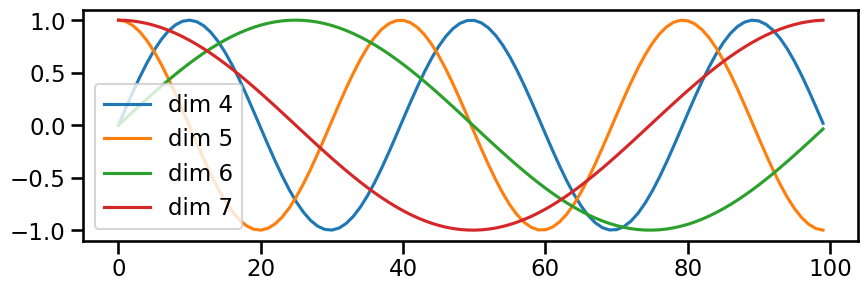

In [51]:
plt.figure(figsize=(10, 3))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

## 完整的模型 

In [52]:
def make_model(src_vocab,
               tgt_vocab,
               N=6,
               d_model=512,
               d_ff=2048,
               h=8,
               dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg. 
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [53]:
tmp_model = make_model(10, 10, 2)
tmp_model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

In [47]:
tmp_model.src_embed

Sequential(
  (0): Embeddings(
    (lut): Embedding(10, 512)
  )
  (1): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

# 训练

## 数据批次，同时创建 mask

In [54]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        """
        src: 输入序列
        trg: 目标序列
        """
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        """
        将 pad 产生的 mask，和序列一次预测下一个单词产生的 mask 结合起来
        """
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [55]:
src = torch.tensor([[3, 5, 7, 0, 0], [2, 4, 6, 8, 0]])  # batch=2,seq_len=5
trg = torch.tensor([[2, 3, 4, 5, 0, 0], [3, 5, 6, 0, 0,
                                         0]])  # batch=2,seq_len=6

sample = Batch(src, trg)
sample.src_mask

tensor([[[ True,  True,  True, False, False]],

        [[ True,  True,  True,  True, False]]])

In [56]:
sample.trg_mask, sample.ntokens

(tensor([[[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True, False]],
 
         [[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True, False, False]]]),
 tensor(5))

## 训练过程

In [57]:
def run_epoch(data_iter, model, loss_compute):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask,
                            batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens  # 总 tokens 数
        tokens += batch.ntokens  # 50 批训练时的总 tokens 数
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                  (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## 训练数据
 standard WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs

In [58]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(mew, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)        

## 优化器

Adam 优化器，参数$\beta_1=0.9$，$\beta_2=0.98$，$\epsilon=10^{-9}$，变学习率：

$$lrate = d_{\text{model}}^{-0.5} \cdot
  \min({step\_num}^{-0.5},
    {step\_num} \cdot {warmup\_steps}^{-1.5})$$
    
其中：    $warmup_{steps}=4000$

In [59]:
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size**(-0.5) *
                              min(step**(-0.5), step * self.warmup**(-1.5)))


def get_std_opt(model):
    return NoamOpt(
        model.src_embed[0].d_model, 2, 4000,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98),
                         eps=1e-9))

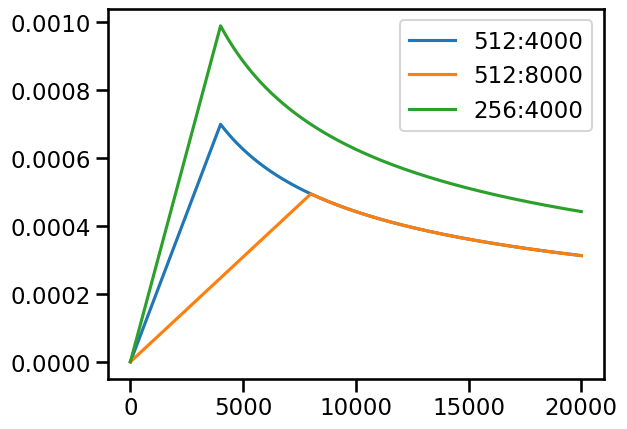

In [60]:
opts = [
    NoamOpt(512, 1, 4000, None),
    NoamOpt(512, 1, 8000, None),
    NoamOpt(256, 1, 4000, None),
]
plt.plot(np.arange(1, 20000),
         [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

## 正则化
标签平滑`Label Smoothing`：$\epsilon_{ls}=0.1$，会降低 perplexity，因为模型将更不确定，但增加精度和`BLEU`分数

In [61]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()

        true_dist.fill_(self.smoothing / (self.size - 2))
        
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

`nn.KLDivLoss`:
输入为`log`概率分布，目标为概率分布；$l(x,y) = L = \{ l_1,\dots,l_N \}, \quad l_n = y_n \cdot \left( \log y_n - x_n \right)$   
指定`reduction`参数时：
$$    \ell(x, y) = \begin{cases}
    \operatorname{mean}(L), & \text{if reduction} = \text{'mean';} \\
    \operatorname{sum}(L),  & \text{if reduction} = \text{'sum'.}
\end{cases}$$

`Tensor.scatter_(dim, index, src)`：
```
x = tensor([[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
            [0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
            [0.1333, 0.1333, 0.1333, 0.1333, 0.1333]])       
index = tensor([[2],
                [1],
                [0]])
x.scatter(1, index, 0.6) -->
tensor([[0.1333, 0.1333, 0.6, 0.1333, 0.1333],
        [0.1333, 0.6, 0.1333, 0.1333, 0.1333],
        [0.6, 0.1333, 0.1333, 0.1333, 0.1333]]) 
    
```
例如上述的五分类中，目标序列 `[2，1，0]` 表示类别 2，1，0。将明确的类别转换成概率分布，使概率分布更均匀些，然后与预测概率分布求损失


/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

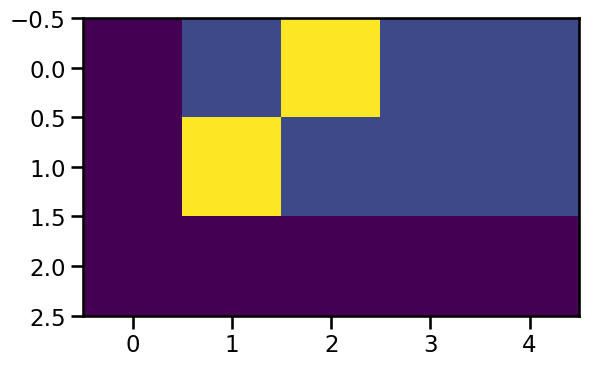

In [62]:
crit = LabelSmoothing(size=5, padding_idx=0, smoothing=0.4)
predict = torch.FloatTensor([
    [0, 0.2, 0.7, 0.1, 0],
    [0, 0.2, 0.7, 0.1, 0],
    [0, 0.2, 0.7, 0.1, 0],
])
v = crit(Variable(predict.log()), Variable(torch.LongTensor([2, 1, 0])))
plt.imshow(crit.true_dist)
crit.true_dist

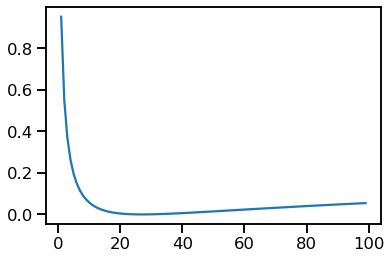

In [62]:
crit = LabelSmoothing(5, 0, 0.1)


def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([
        [0, x / d, 1 / d, 1 / d, 1 / d],  # 概率分布，x 的值越大，标签 1 的概率越大
    ])
    #print(predict)
    return crit(
        Variable(predict.log()),
        Variable(torch.LongTensor([1])),  # 真实标签为 1
    ).item()


plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

## 测试模型

In [63]:
# 生成随机数据
def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [64]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator  # 模型最后的输出层
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm

In [ ]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(
    model.src_embed[0].d_model, 1, 400,
    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model,
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(
        run_epoch(data_gen(V, 30, 5), model,
                  SimpleLossCompute(model.generator, criterion, None)))

## 解码算法

In [66]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, Variable(ys),
            Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat(
            [ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys


model.eval()
src = Variable(torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]))
src_mask = Variable(torch.ones(1, 1, 10))
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  5, 10,  8,  5, 10,  8,  5, 10,  8]])


# 实战

In [67]:
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load("de_core_news_sm")
    spacy_en = spacy.load("en_core_web_sm")

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de,
                     pad_token=BLANK_WORD)  # 定义预处理流程，分词、填充、
    TGT = data.Field(tokenize=tokenize_en,
                     init_token=BOS_WORD,
                     eos_token=EOS_WORD,
                     pad_token=BLANK_WORD)

    MAX_LEN = 100

    # 数据集
    train, val, test = datasets.IWSLT.splits(
        exts=('.de', '.en'),
        fields=(SRC, TGT),
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(
            vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2

    # 创建词汇表
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

ModuleNotFoundError: No module named 'torchtext'

In [ ]:
# 数据分批对训练速度很重要：需要拆分成均匀的批次，最小的填充
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train: # 训练模式，数据分批，然后打乱顺序

            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(sorted(p, key=self.sort_key),
                                         self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b

            self.batches = pool(self.data(), self.random_shuffler)

        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))


def rebatch(pad_idx, batch): # batch first --> True
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

## 并行计算

In [ ]:
# 使用 multi-gpu 加速训练速度：将单词生成拆分成块，便于并行处理
class MultiGPULossCompute:
    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size

    def __call__(self, out, targets, normalize):
        
        total = 0.0
        
        # 将最终的线性输出层 并行 到多个 gpu中
        generator = nn.parallel.replicate(self.generator, devices=devices)
        
        # 将 transformer 的输出张量 并行 多个 gpu 中
        out_scatter = nn.parallel.scatter(out, target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        
        # 将目标 并行 到多个 gpu 中
        targets = nn.parallel.scatter(targets, target_gpus=self.devices)

        # 将生成拆分成块？？
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):

            # 预测分布
            out_column = [[
                Variable(o[:, i:i + chunk_size].data,
                         requires_grad=self.opt is not None)
            ] for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # 计算损失
            y = [(g.contiguous().view(-1, g.size(-1)),
                  t[:, i:i + chunk_size].contiguous().view(-1))
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # 损失求和并归一化
            l = nn.parallel.gather(loss, target_device=self.devices[0])
            l = l.sum()[0] / normalize
            total += l.data[0]

            # 反向传播
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # 反向传播整个模型
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

In [ ]:
devices = [0, 1, 2, 3]
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab),
                               padding_idx=pad_idx,
                               smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 12000
    train_iter = MyIterator(train,
                            batch_size=BATCH_SIZE,
                            device=0,
                            repeat=False,
                            sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn,
                            train=True)
    valid_iter = MyIterator(val,
                            batch_size=BATCH_SIZE,
                            device=0,
                            repeat=False,
                            sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn,
                            train=False)
    model_par = nn.DataParallel(model, device_ids=devices)

In [ ]:
if False:
    model_opt = NoamOpt(
        model.src_embed[0].d_model, 1, 2000,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98),
                         eps=1e-9))
    for epoch in range(10):
        model_par.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), model_par,
                  MultiGPULossCompute(model.generator,
                                      criterion,
                                      devices=devices,
                                      opt=model_opt))
        model_par.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), model_par,
                         MultiGPULossCompute(model.generator,
                                             criterion,
                                             devices=devices,
                                             opt=None))
        print(loss)
else:
    model = torch.load("iwslt.pt")

In [ ]:
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model,
                        src,
                        src_mask,
                        max_len=60,
                        start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end=" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end=" ")
    print()
    break

# 额外的组件

## `BPE/ Word-piece`：将单词拆分成 子词

## 共享权重：输入与目标的嵌入矩阵相同

In [ ]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight

## `Beam Search`

https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/beam_search.py

## `Model Averaging`：将最后 k 个 checkpoint 平均，创造组合模型

In [ ]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        p[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

# 注意力可视化

In [ ]:
tgt_sent = trans.split()


def draw(data, x, y, ax):
    seaborn.heatmap(data,
                    xticklabels=x,
                    square=True,
                    yticklabels=y,
                    vmin=0.0,
                    vmax=1.0,
                    cbar=False,
                    ax=ax)


for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Encoder Layer", layer + 1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data,
             sent,
             sent if h == 0 else [],
             ax=axs[h])
    plt.show()

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Decoder Self Layer", layer + 1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].
             data[:len(tgt_sent), :len(tgt_sent)],
             tgt_sent,
             tgt_sent if h == 0 else [],
             ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer + 1)
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].
             data[:len(tgt_sent), :len(sent)],
             sent,
             tgt_sent if h == 0 else [],
             ax=axs[h])
    plt.show()